In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import aic, bic


In [4]:
factor_data = pd.read_csv('./BTC_10m_active_3m_6m.csv')
factor_data['datetime'] = pd.to_datetime(factor_data['datetime'])
factor_data = factor_data.set_index('datetime')
# factor_data.query('datetime >= "2023-01-01"', inplace=True)

# factor_data['active_3m_6m'] = np.log(factor_data['active_3m_6m'] + 1)

factor_data_10m = factor_data
factor_data_1h = factor_data.resample('1h').mean()
factor_data_1d = factor_data.resample('1D').mean()

factor_data_1d.query('datetime >= "2023-01-01"', inplace=True)

In [5]:
factor_data_1d

,active_3m_6m
datetime,
2023-01-01,8.947136e+05
2023-01-02,8.929458e+05
2023-01-03,8.926328e+05
2023-01-04,8.951429e+05
2023-01-05,8.971683e+05
...,...
2025-06-03,2.198688e+06
2025-06-04,2.067080e+06
2025-06-05,1.932565e+06


In [6]:
factor_data_1d_demo = factor_data_1d.copy()
factor_data_1d_demo['lag_1'] = factor_data_1d_demo['active_3m_6m'].shift(1)
factor_data_1d_demo.dropna(inplace=True)
px.line(factor_data_1d_demo, x=factor_data_1d_demo.index, y=['active_3m_6m', 'lag_1'], title='Active 3m-6m and Lag 1 Day').show()

In [7]:
px.line(factor_data_1d)

In [8]:
# def adf_test(series):
#     result = adfuller(series)
#     print(f'ADF Statistic: {result[0]}')
#     print(f'p-value: {result[1]}')
#     if result[1] < 0.05:
#         print("数据平稳")
#     else:
#         print("数据非平稳")

# # 进行平稳性检验, 原始因子时间序列不平稳， 经过差分之后平稳
# adf_test(factor_data_1d.dropna())

adfuller(factor_data_1d['active_3m_6m'].dropna())


(-3.6084962959966926,
 0.005600658893362316,
 14,
 874,
 {'1%': -3.437854130362047,
  '5%': -2.8648525821630173,
  '10%': -2.5685338603647714},
 20214.493853956155)

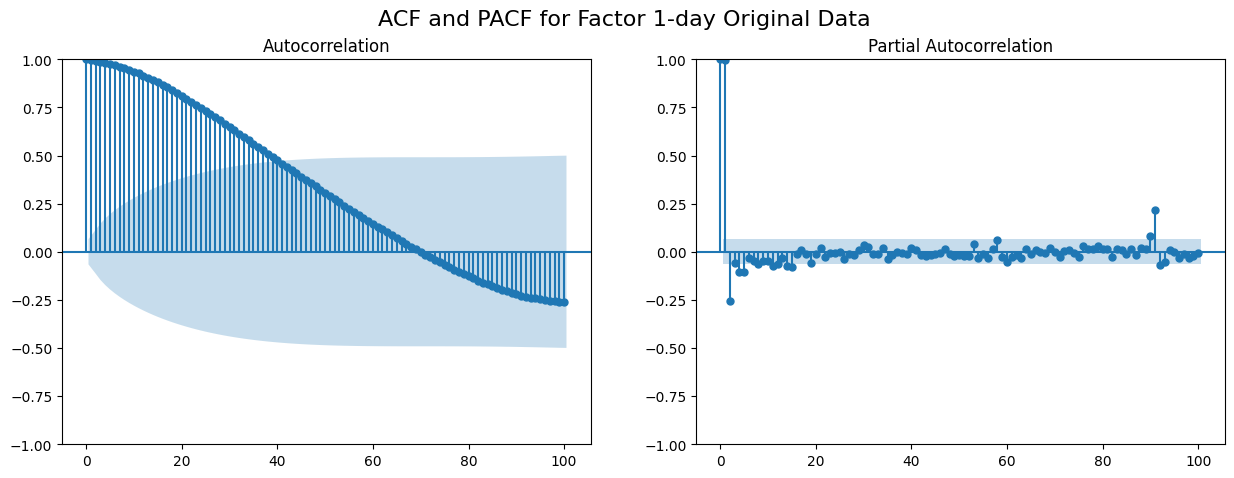

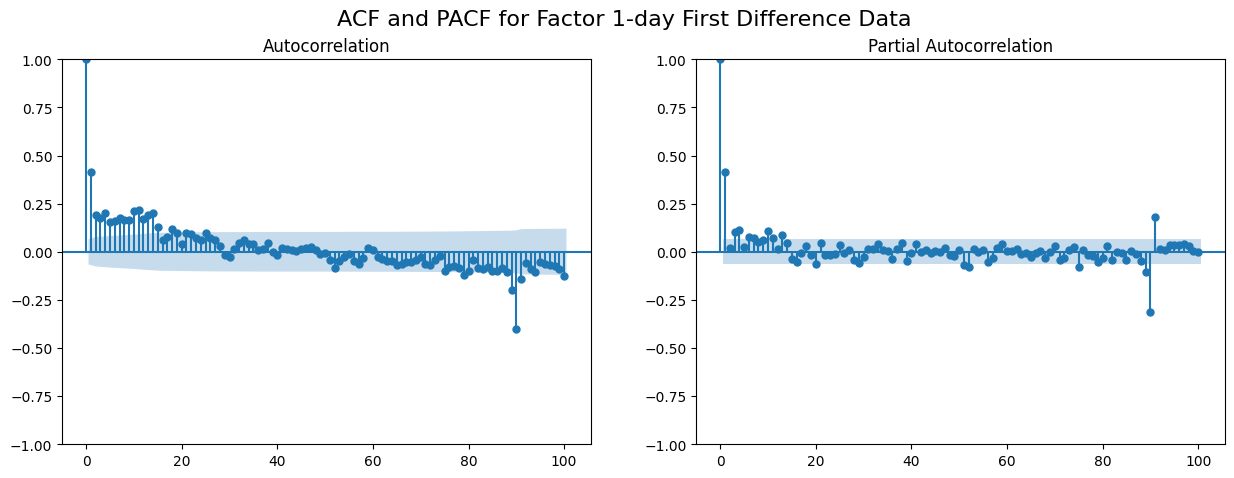

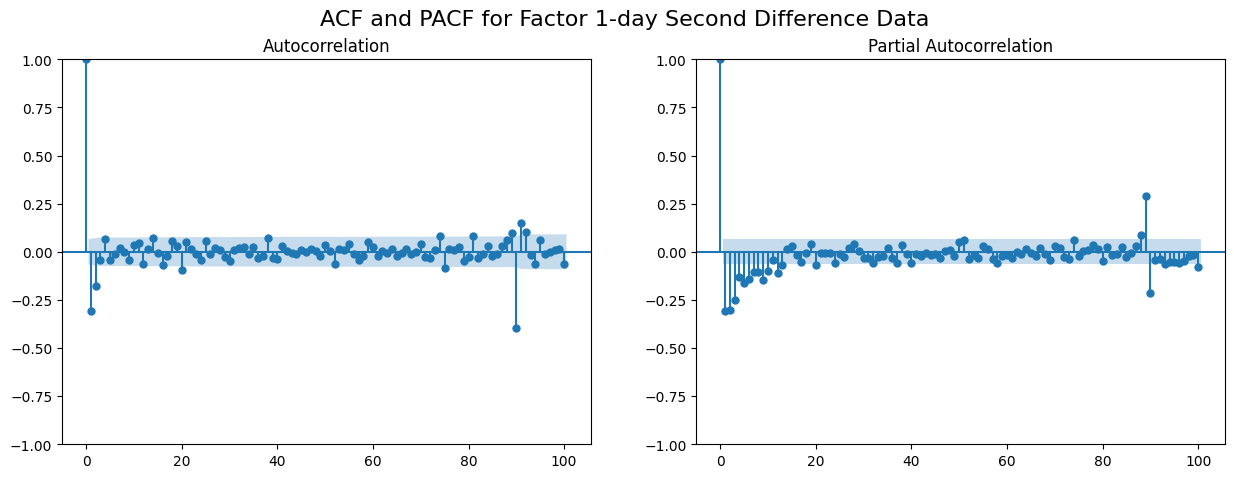

In [9]:
def plot_acf_pacf(series, freq_label="Frequency"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(series, lags=100, ax=axes[0])
    plot_pacf(series, lags=100, ax=axes[1])
    fig.suptitle(f"ACF and PACF for Factor {freq_label} Data", fontsize=16)
    plt.show()


# Plot ACF and PACF for 1-day frequency differenced data
plot_acf_pacf(factor_data_1d.dropna(), "1-day Original")

plot_acf_pacf(factor_data_1d.diff().dropna(), "1-day First Difference")

plot_acf_pacf(factor_data_1d.diff().diff().dropna(), "1-day Second Difference")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



AIC: 17234.312847201407
BIC: 17262.405498786105


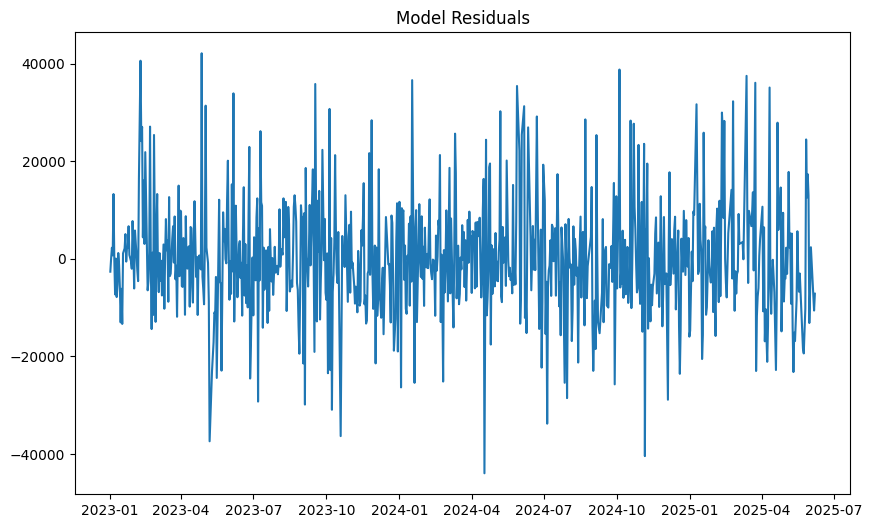

In [10]:
# 拟合 ARMA 模型
factor = factor_data_1d.diff().dropna()
# 去除top和bottom 1% 的异常值
lower_bound = factor['active_3m_6m'].quantile(0.05)
upper_bound = factor['active_3m_6m'].quantile(0.95)
factor = factor[(factor['active_3m_6m'] >= lower_bound) & (factor['active_3m_6m'] <= upper_bound)]



p, q = 2, 2
model = ARIMA(factor, order=(p, 0, q))  # ARMA 没有差分部分，所以差分阶数 d=0
model_fit = model.fit()

# 5. 模型诊断：查看 AIC 和 BIC
print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')

# 6. 残差分析
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Model Residuals")
plt.show()

In [12]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.simplefilter("ignore")

# 假设 factor_data_1h 是你的原始数据，'active_3m_6m' 是你要分析的因子列
factor = factor_data_1h
div_num = 12


# 去除异常值（上下5%的数据）
lower_bound = factor.quantile(0.05)
upper_bound = factor.quantile(0.95)
factor = factor[(factor >= lower_bound) & (factor <= upper_bound)]
factor.asfreq = 'H'


n = len(factor)
split_size = n // div_num  # 计算每份数据的大小
chunks = [factor[i:i + split_size] for i in range(0, n, split_size)]

# 如果不能整除，最后一段数据可能会少一些，补充完整
if len(chunks) < div_num:
    chunks[-2] = pd.concat([chunks[-2], chunks[-1]])  # 将最后一段合并到倒数第二段
    chunks = chunks[:-1]  # 移除最后一段（数据会平滑分布）

# 定义 p 和 q 的范围
p_values = range(0, 5)  # ARIMA的p的值
q_values = range(0, 5)  # ARIMA的q的值
# d_values = [0, 1, 2]
d_values = [0]

# 用于存储每个月的 AIC 和 BIC
results = []

# 对每个分段的数据进行建模
for i, data in enumerate(chunks):
    for p in p_values:
        for q in q_values:
            for d in d_values:
                try:
                    # 训练 ARIMA 模型
                    model = ARIMA(data, order=(p, d, q))  # 这里 d=0 表示没有差分部分
                    model_fit = model.fit()

                    # 获取 AIC 和 BIC 值
                    aic = model_fit.aic
                    bic = model_fit.bic

                    # 将结果添加到 monthly_results 中
                    results.append({'Segment': i+1, 'p': p, 'q': q, 'AIC': aic, 'BIC': bic})
                    print(f"Segment {i+1} | ARIMA({p}, 0, {q}) - AIC: {aic}, BIC: {bic}")

                except Exception as e:
                    print(f"Error fitting model ARIMA({p}, 0, {q}) for Segment {i+1}: {e}")
                    continue

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)


Segment 1 | ARIMA(0, 0, 0) - AIC: 117965.54519446596, BIC: 117977.71061673443
Segment 1 | ARIMA(0, 0, 1) - AIC: 92614.16672000977, BIC: 92632.41485341248
Segment 1 | ARIMA(0, 0, 2) - AIC: 92024.67866885301, BIC: 92049.00951338996
Segment 1 | ARIMA(0, 0, 3) - AIC: 91880.7154018569, BIC: 91911.12895752808
Segment 1 | ARIMA(0, 0, 4) - AIC: 91841.40858598467, BIC: 91877.90485279009
Segment 1 | ARIMA(1, 0, 0) - AIC: 62611.31873701473, BIC: 62629.56687041744
Segment 1 | ARIMA(1, 0, 1) - AIC: 62157.18432774262, BIC: 62181.51517227957
Segment 1 | ARIMA(1, 0, 2) - AIC: 62143.78864299457, BIC: 62174.20219866576
Segment 1 | ARIMA(1, 0, 3) - AIC: 62143.4023361328, BIC: 62179.89860293823
Segment 1 | ARIMA(1, 0, 4) - AIC: 62144.856417198826, BIC: 62187.43539513849
Segment 1 | ARIMA(2, 0, 0) - AIC: 62151.644557393025, BIC: 62175.97540192997
Segment 1 | ARIMA(2, 0, 1) - AIC: 62141.46524719393, BIC: 62171.87880286512
Segment 1 | ARIMA(2, 0, 2) - AIC: 62160.892176468136, BIC: 62197.388443273565
Segment 

In [13]:
results_df['param'] = results_df.apply(lambda row: f"ARIMA({int(row['p'])},0,{int(row['q'])})", axis=1)
results_df['metric'] = results_df['AIC'] + results_df['BIC']

In [14]:

fig1 = px.line(results_df, x='Segment', y='AIC', color='param', title='AIC Values for Different ARIMA Models Across Segments')
fig2 = px.line(results_df, x='Segment', y='BIC', color='param', title='BIC Values for Different ARIMA Models Across Segments')
fig3 = px.line(results_df, x='Segment', y='metric', color='param', title='AIC + BIC Values for Different ARIMA Models Across Segments')
fig1.show()
fig2.show()
fig3.show()

In [15]:
results_df

,Segment,p,q,AIC,BIC,param,metric
0,1,0,0,117965.545194,117977.710617,"ARIMA(0,0,0)",235943.255811
1,1,0,1,92614.166720,92632.414853,"ARIMA(0,0,1)",185246.581573
2,1,0,2,92024.678669,92049.009513,"ARIMA(0,0,2)",184073.688182
3,1,0,3,91880.715402,91911.128958,"ARIMA(0,0,3)",183791.844359
4,1,0,4,91841.408586,91877.904853,"ARIMA(0,0,4)",183719.313439
...,...,...,...,...,...,...,...
295,12,4,0,41258.416685,41294.912952,"ARIMA(4,0,0)",82553.329637
296,12,4,1,41265.795720,41308.374698,"ARIMA(4,0,1)",82574.170418
297,12,4,2,41258.847185,41307.508874,"ARIMA(4,0,2)",82566.356059
298,12,4,3,41267.256204,41322.000604,"ARIMA(4,0,3)",82589.256808


In [16]:
results_df

avg_results_df = results_df.groupby(['param']).mean().sort_values(by=['metric']).drop(columns=['p', 'q', 'Segment']).reset_index()
avg_results_df

,param,AIC,BIC,metric
0,"ARIMA(4,0,0)",56747.244205,56783.740471,113530.984676
1,"ARIMA(2,0,1)",56751.835814,56782.249369,113534.085183
2,"ARIMA(2,0,2)",56749.819531,56786.315798,113536.135329
3,"ARIMA(1,0,3)",56750.747592,56787.243859,113537.991451
4,"ARIMA(1,0,2)",56753.811694,56784.225250,113538.036944
5,"ARIMA(3,0,0)",56755.023332,56785.436887,113540.460219
6,"ARIMA(3,0,1)",56753.100953,56789.597220,113542.698172
7,"ARIMA(3,0,2)",56750.228873,56792.807851,113543.036724
8,"ARIMA(2,0,3)",56750.592080,56793.171057,113543.763137
9,"ARIMA(2,0,0)",56763.606869,56787.937714,113551.544583


In [17]:
results_df.sort_values(by=['metric']).head(10)

,Segment,p,q,AIC,BIC,param,metric
135,6,2,0,41195.670348,41220.001193,"ARIMA(2,0,0)",82415.671541
131,6,1,1,41196.987268,41221.318112,"ARIMA(1,0,1)",82418.305380
136,6,2,1,41197.646167,41228.059723,"ARIMA(2,0,1)",82425.705890
140,6,3,0,41197.647192,41228.060748,"ARIMA(3,0,0)",82425.707939
132,6,1,2,41197.982100,41228.395655,"ARIMA(1,0,2)",82426.377755
145,6,4,0,41197.902681,41234.398948,"ARIMA(4,0,0)",82432.301630
133,6,1,3,41199.265407,41235.761674,"ARIMA(1,0,3)",82435.027081
141,6,3,1,41199.638615,41236.134881,"ARIMA(3,0,1)",82435.773496
137,6,2,2,41200.969296,41237.465563,"ARIMA(2,0,2)",82438.434860
134,6,1,4,41199.403602,41241.982580,"ARIMA(1,0,4)",82441.386182


In [18]:
train_data = factor_data_1d[: int(len(factor_data_1d)*0.8)]
train_data

selected_model = ARIMA(train_data, order=(4, 0, 1))  # 这里 d=0 表示没有差分部分
model_fit = selected_model.fit()

In [19]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           active_3m_6m   No. Observations:                  711
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -8226.464
Date:                Wed, 05 Nov 2025   AIC                          16466.928
Time:                        21:35:02   BIC                          16498.895
Sample:                    01-01-2023   HQIC                         16479.276
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.457e+06   7.56e-09   1.93e+14      0.000    1.46e+06    1.46e+06
ar.L1          2.1706      0.035     62.767      0.000       2.103       2.238
ar.L2         -1.4934      0.075    -19.959      0.0

In [20]:
px.line(model_fit.resid)

In [21]:
from pykalman import KalmanFilter

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(model_fit.resid, n_iter=10)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(model_fit.resid)
px.line(smoothed_state_means)

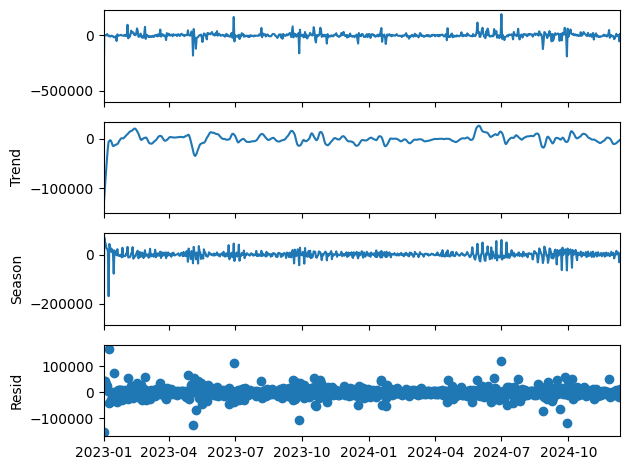

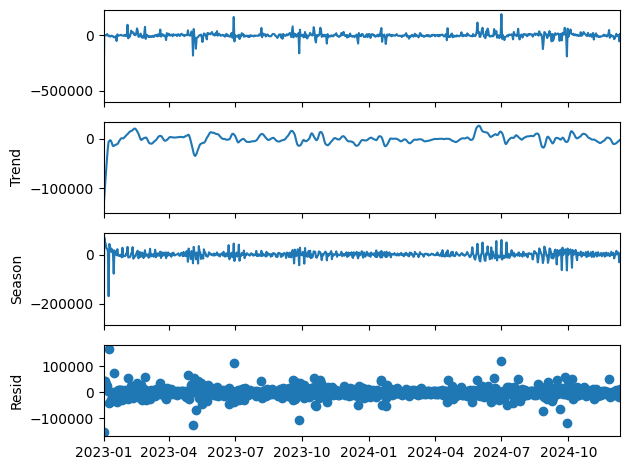

In [22]:
from statsmodels.tsa.seasonal import STL
model_resid = model_fit.resid.dropna()

# 使用STL分解残差序列
stl = STL(model_resid)
result = stl.fit()
result.plot()


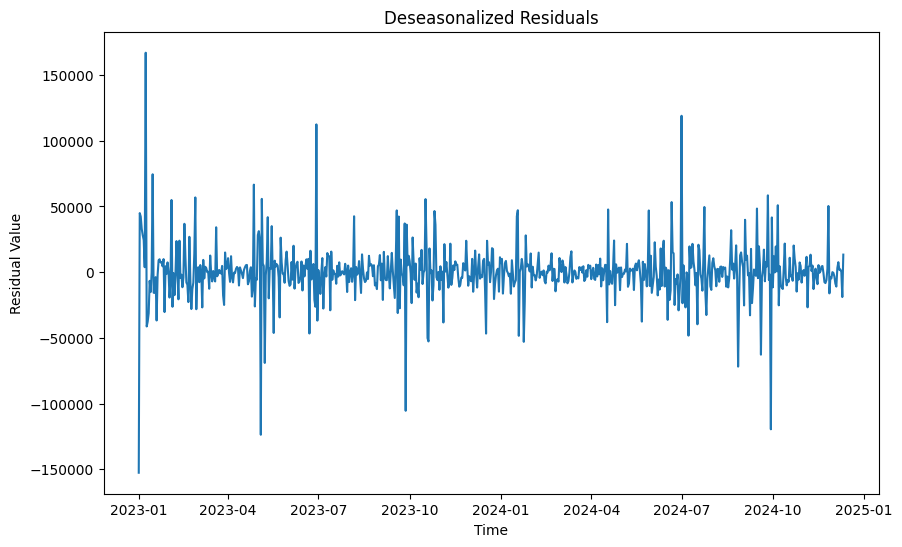

In [23]:
deseasonalized_residuals = result.resid

# 绘制去季节性后的残差
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_residuals)
plt.title("Deseasonalized Residuals")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.show()

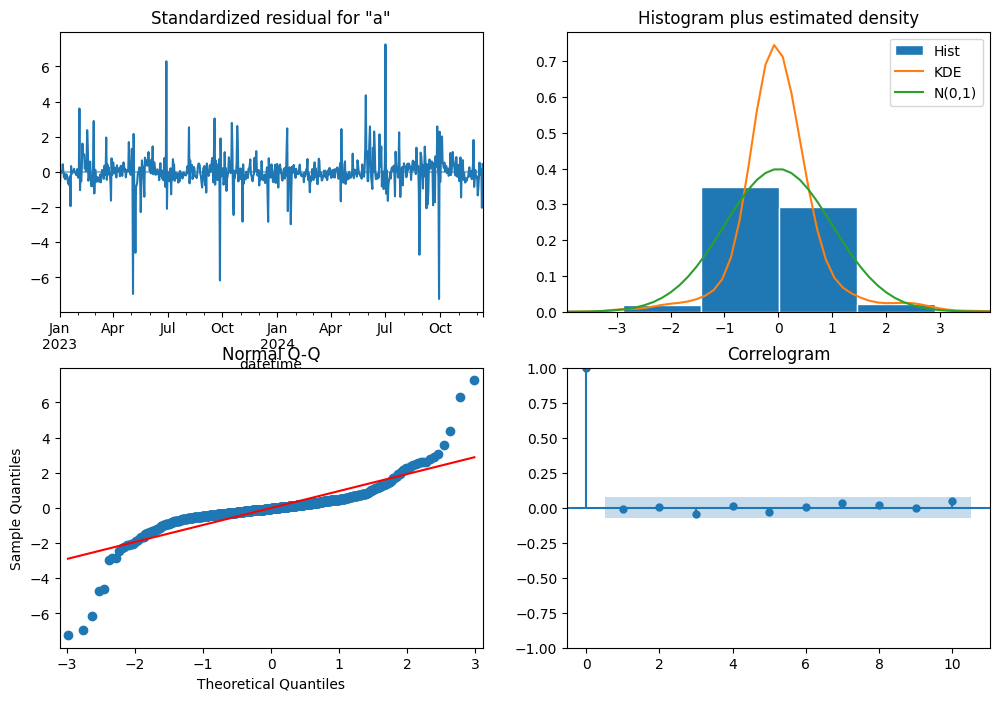

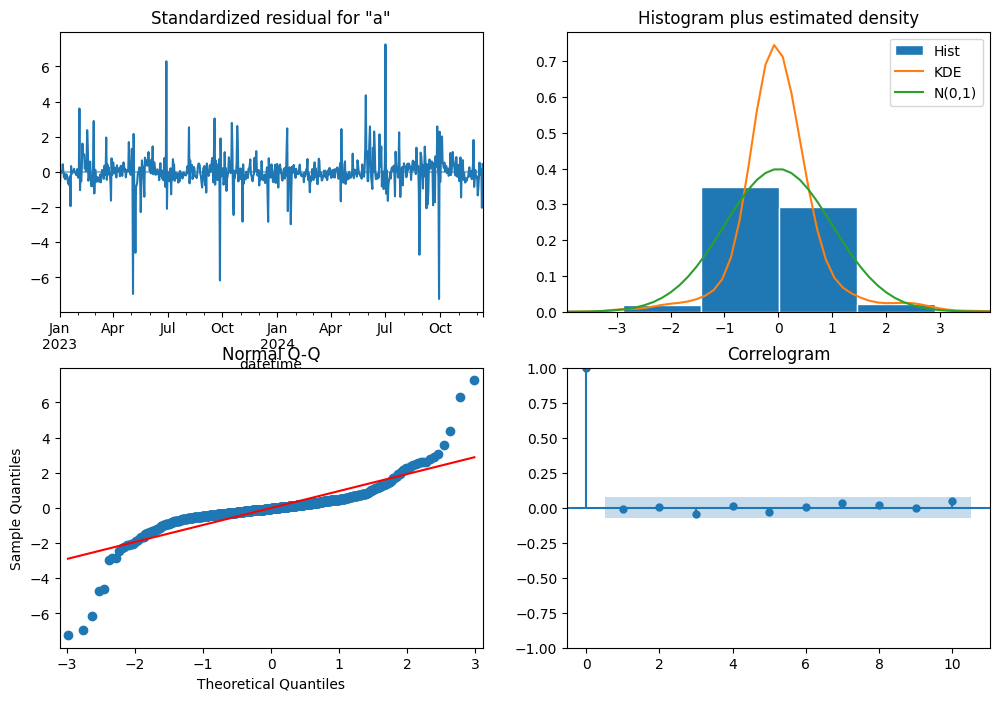

In [24]:
model_fit.plot_diagnostics(figsize=(12, 8))